## Problem 3: Simulating Vehicle Traffic : Continued

### a) The 4-way traffic intersection can be posed as a simple Markov Decision Process(MDP), $\mathcal{M} \triangleq (\mathcal{X,A},P,R) $, where: 

* **States:**  $\mathcal{X}$ be the set of states $\mathbf{x_t}$. Where a state $\mathbf{x_t} \equiv [x_t(\frac{E}{L}), x_t(\frac{E}{F}), x_t(\frac{N}{L}), x_t(\frac{N}{F}), x_t(\frac{W}{L}), x_t(\frac{W}{F}), x_t(\frac{S}{L}), x_t(\frac{S}{F})]$ and $x_t(D/i) \in \mathbb{Z}^{\geq 0} $ refers to the number of vehicles that are present in direction $D = \{E,N,W,S\}$ and lane i of the intersection at time t and thus $\mathbf{x_t}$ is a vector of all $x_t(D/i)$. This definition is similar to that of HW1 problem 4. 

* **Actions:** $\mathcal{A}$ be the set of actions taken by traffic lights. By analysing the intersection, we see that this set can be split into two parts, i.e. straight line motion of traffic and adjacent motion of traffic, and by extension a combination of both. Therefore, $\mathcal{A} = \{\{\{(E/W), (N/S)\} \times \{F,L\}\} \cup \{\{E,N,W,S\} \times \{(F/L)\}\}\} = \{(E/W, F), (E/W,L), (N/S, F), (N/S, L), (E, F/L), (N, F/L), (W, F/L), (S, F/L)\}$.

* **Transition Probability:** $P \equiv P_a(\mathbf{x_{t+1}|x_t})$.
    There are two factors which impact the transition from t to t+1:  (i)number of incoming vehicles (+ vehicles) and (ii)number of vehicles leaving due to action a (- vehicles). 
     
    (i) In HW 1 Problem 4, we model the vehical arrival process $Y_D(t)$ as a homogeneous compound Poisson process with arrival rates  $\lambda_D = \{5, 5, 10, 7\}$, platoons per minutes. The jump magnitude (platoon sizes), $\{\psi_n^{(D)}\}_{n} \sim U[1,3]$ vehicles, where $\psi^{(D)}_n \in \mathbb{N}$ is the number of simultaneous vehicle arrivals from direction D at arrival time $T^{(D)}_n$. The probability of a car choosing a lane L/R was defined as $P_i = {P_F, P_L} = {0.7, 0.3}$

    (ii) In HW 1 Problem 4, we define an action, a, has a duration of $t_a = 10$ seconds and rate of vehicle departing the intersection $v_{D,i} = min(x_t(D,i),1)$ for all D,i given in action a. 

    So, $P_a(\mathbb{x_{t+1}|x_t}) = \prod_{d \in \{E, N, W, S\}} \prod_{i \in \{F, L\}} P_d^i(x_{t+1}, a | x_t)$,

    $P_d^i(x_{t+1}, a | x_t) = P_d^i (x_{t+1} - x_t, a)$, and n(arriving) - n(leaving) = $x_{t+1} - x_t$, where leaving = 1 if d,i in a, else 0.
    $\mathbb{E}[\text{jump size}] = (1 + 3) / 2 = 2, Var[\text{jump size}] = (3 - 1)^2 / 12 = 1$

    case 1, i,d not in a: 
    
    $P_d^i (x_{t+1} - x_t = k, a) =  \exp(-λ) \frac{(λ)^k}{k!} (\mathbb{E}[\text{jump size}])^k \left(\frac{1}{\sqrt{2 \pi Var[\text{jump size}]}}\right)^k$, k=1,2,3

    case 2, i,d in a: then n(arriving)+1 =$x_{t+1}-x_t$, so e.g. $x_t = 3, x_{t+1} = 5$ means, n(arriving) = 3, n(leaving) = 1
    
    $P_d^i (x_{t+1} - x_t = k, a) =  \exp(-λ)\frac{(λ)^{(k+1)} }{(k+1)!}(\mathbb{E}[\text{jump size}])^{(k+1)} \left(\frac{1}{\sqrt{2 \pi Var[\text{jump size}]}}\right)^{(k+1)}$, k=1,2,3

    
* **Rewards:** $R \equiv R_a(x_{t}, x_{t+1})$ is the reward obtained by transitioning from state $x_{t}$ to $x_{t+1}$ by taking action $a \in A$.

    We define 
    
    $R_a(x_{t}, x_{t+1}) = \sum_{(d,i) \in a} (1 \text{, if }x_{t+1}^{(d,i)} -x_{t}^{(d,i)} <0 + \nu; -1\text{, if }x_{t+1}^{(d,i)} -x_{t}^{(d,i)} > 10 + \nu) $ , where $\nu$ is the relaxation parameter, and $\alpha = 0$ implies reward is only given when number of vehicles in  = out between these timesteps. To avoid the case where the agent sticks to one action such as (E/W F), we penalise the agent when the number of cars increase over some arbitrary number (10). 

#### classes implementation for the RL task


In [3]:
# a class to keep track of state vector in part c
import matplotlib.pyplot as plt
import random
import copy
import pandas as pd
import numpy as np

# representation of xt defined in HW1 Simulation Vehicle traffic
class x_state:
    def __init__(self):
        self.state = {'E': {'F': 0, 'L': 0}, 'N': {'F': 0, 'L': 0}, 'W': {'F': 0, 'L': 0}, 'S': {'F': 0, 'L': 0}}
    
    def __eq__(self, other):
        if isinstance(other, x_state):
            return self.state == other.state
        return False
    
    def self_sum(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]
        return result

    def distance_metric(self, other):
        if isinstance(other, x_state):
            difference = self - other
            return difference.sum_and_square()
        
        else:
            raise ValueError("Distance metric is only defined for x_state objects.")

    def sum_and_square(self):
        result = 0
        for direction in self.state:
            for lane in self.state[direction]:
                # Calculate the sum of values within each direction and square the result
                result += self.state[direction][lane]

        return result**2
    
    def __sub__(self, other):
        if isinstance(other, x_state):
            result_state = {}
            for direction in self.state:
                result_state[direction] = {}
                for lane in self.state[direction]:
                    result_state[direction][lane] = self.state[direction][lane] - other.state[direction][lane]
            new_x_state = x_state()
            new_x_state.state = result_state
            return new_x_state
        else:
            raise ValueError("Subtraction is only defined for x_state objects.")
        
    def to_numpy(self):
        return np.array(self.__get_values_tuple())
    
    def __get_values_tuple(self):
        # Use a nested list comprehension to extract values from inner dictionaries
        values_list = [value for inner_dict in self.state.values() for value in inner_dict.values()]
        # Convert the list of values into a tuple
        values_tuple = tuple(values_list)
        return values_tuple

    def __hash__(self):
        # To make the object hashable, convert the nested dictionaries to a frozenset
        return hash(self.__get_values_tuple())
    
    def __str__(self):
        result = ""
        for direction, values in self.state.items():
            result += f"{direction}: F={values['F']}, L={values['L']}, "
        return result

class memory():
    def __init__(self, q_table) -> None:
         # columns: "distance metric-sum of elemnts ^2, optimal action, optimal R_a"
         self.columns =['d', 'a', 'R']
         self.memory_table = pd.DataFrame(columns=self.columns)
         self.initialise_with_q_table(q_table=q_table)
         self.size_time = np.zeros(300)
         self.size_time[0] = self.memory_table.shape[0]
         self.short_term_Q = pd.DataFrame(columns=q_table.columns, dtype=np.float64)
    
    def update_size_time_array(self,i):
        self.size_time[i] = self.memory_table.shape[0]

    def initialise_with_q_table(self, q_table):
        for s in q_table.index:
            d = s.self_sum()
            a = q_table.columns[np.nanargmax(q_table.loc[s])]
            r = q_table.loc[s,a]
            self.insert(s,d,self.parse_formatted_action(a),r)
        
    def insert(self, state, d, a, r):
        if state not in self.memory_table.index:
            new_row = pd.Series([d,a,r], 
                                index=self.columns, 
                                name=state)
            self.memory_table = pd.concat([self.memory_table, new_row.to_frame().T])
        else:
            if self.memory_table['R'][state]<(r-2):
                self.memory_table['a'][state] = a
                self.memory_table['R'][state] = r

    # def insert(self, state):
        
    #     if state not in self.memory_table.index:
    #          # check if the 
    #          pass

    # return the action when its in memory or close to state otherwise 
    def get_action_from_memory(self, state):
        d = state.self_sum()
        tolerance = 2
        in_memory = False
        a = None
        if state not in self.memory_table.index:
            # find the nearest state
            # Use boolean indexing to find the rows where column 'd' is within 2 units of the target value
            result = self.memory_table[(self.memory_table['d'] >= d - tolerance) & (self.memory_table['d'] <= d + tolerance)]
            if(result.size!=0):
                # found the nearest state
                max_state = result.index[np.argmax(result['R'])]
                # Get the indices of the selected rows
                a = self.memory_table['a'][max_state]
                R = self.memory_table['R'][max_state]
                self.insert(state=state, d=d, a=a, r=R)
                in_memory = True
            
        else:
            in_memory = True
            a = self.memory_table['a'][state]

        return in_memory, a
            
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
            try:
                # Remove the parentheses and split the string into two parts
                parts = formatted_action.strip("()").split("),(")
                
                if len(parts) != 2:
                    raise ValueError("Invalid formatted action string")

                # Split the two parts into lists
                part1 = parts[0].split(',')
                part2 = parts[1].split(',')

                # Return the parsed action
                return (part1, part2)
            except ValueError as e:
                print(f"Error parsing formatted action: {e}")
                return None


    

class vehicles:
    def __init__(self, duration) -> None:
        self.duration = duration
        # arrival rates in lamda platoons per second
        self.arrival_rates = {'E': 5/60, 'N': 5/60, 'W': 10/60, 'S': 7/60}
        self.line_assignment_p = [0.7, 0.3]
        self.lanes = ['F', 'L']
        self.arrival_times_df, self.departure_times_df = self.generate_arrival_times_with_lanes()
        self.vehicle_depart_index = {'E': {'F': 0, 'L': 0}, 'N': {'F': 0, 'L': 0}, 'W': {'F': 0, 'L': 0}, 'S': {'F': 0, 'L': 0}}
      
    def move_vehicle(self, next_state, current_action, i):
        for direction in self.arrival_rates.keys():
            for lane in self.lanes:
                column = self.arrival_times_df[(direction,lane)]
                count = ((column >= i) & (column < i+1)).sum()
                next_state.state[direction][lane] += count
        # Calculate departing vehicles
        if i >= 1:
            for direction in current_action[0]:
                for lane in current_action[1]:
                    if next_state.state[direction][lane]>0:
                        # update the state that vehicle is gone
                        next_state.state[direction][lane]-=1

                        # update my vehicles df and add the departure time
                        last_index = self.vehicle_depart_index[direction][lane]
                        next_index = (self.arrival_times_df[(direction,lane)][last_index:].notna()).idxmax()
                        
                        
                        if not pd.isna(next_index):
                            self.departure_times_df[(direction,lane)][next_index] = i + 1
                            self.vehicle_depart_index[direction][lane] = next_index+1
        

    def generate_arrival_times_with_lanes(self):
        self.arrival_times = self.generate_arrival_times()
        # print(arrival_times)
        df = pd.DataFrame(self.arrival_times)
        # Use the explode function to convert lists into separate rows
        df = df.apply(lambda x: x.explode(), axis=0)
        # Reset the index
        df = df.reset_index(drop=True)


        # Create lane assignments for each cell in the DataFrame
        lane_assignments = np.random.choice(self.lanes, size=df.shape, p=self.line_assignment_p)

        # Split the original DataFrame into separate DataFrames based on lane assignments
        # Initialize an empty DataFrame to store the split data
        split_dfs = []
        for lane in self.lanes:
            mask = lane_assignments == lane
            split_data = df.values * mask
            split_df = pd.DataFrame(split_data, columns=[(col,lane) for col in df.columns])
            split_dfs.append(split_df)

        # Combine the split DataFrames into a single DataFrame
        arrival_times_df = pd.concat(split_dfs, axis=1)
        arrival_times_df = arrival_times_df.replace(0, np.nan)
        arrival_times_df[arrival_times_df>=self.duration] = np.nan
        arrival_times_df = arrival_times_df.dropna(how='all').reset_index(drop=True)
        departure_times_df = pd.DataFrame(columns=arrival_times_df.columns, index=arrival_times_df.index)

        return arrival_times_df, departure_times_df

    def generate_arrival_times(self):
        # generate arrival times
        t = 0
        arrival_times = []
        for i in range(self.duration):
            # Simulate the homogeneous Poisson process for arrival times
            times = {'E':[], 'N': [], 'W': [], 'S': []}
            while t <= i:
                for direction in self.arrival_rates.keys():
                    inter_arrival_time = random.expovariate(self.arrival_rates[direction])
                    t += inter_arrival_time
                    times[direction].append(t)
            arrival_times.append(times)
        return arrival_times
  
    

# a list of states in time with different methods to check for unique states and plotting the state graphs
class x_state_t:
    def __init__(self, duration, action_duration, arrival_rates, A,  alpha=0.7, gamma=0.3, epsilon=0.4):
        self.states = [x_state() for _ in range(duration)]
        self.unique_states = {} # make it a dic
        self.interarrival_times = {}

        self.duration = duration
        self.action_duration = action_duration
        self.i = 0
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = A
        self.current_action = self.get_next_action(self.states[self.i], first=True) # the first action

        self.arrival_rates = arrival_rates
        self.arrival_times = self.generate_arrival_times()
        action_strings = [self.format_action(action) for action in self.actions]
        self.q_table = pd.DataFrame(columns=action_strings, dtype=np.float64)

        self.vehicles = vehicles(duration=duration)
       
        
    def reset(self):
        self.states = [x_state() for _ in range(self.duration)]
        self.unique_states = {} # make it a dic
        self.interarrival_times = {}
        self.i = 0
        self.current_action = self.get_next_action(self.states[self.i], first=True) # the first action
        self.arrival_times = self.generate_arrival_times()
        self.vehicles = vehicles(self.duration)
  
    def reset_test(self):
        self.states = [x_state() for _ in range(self.duration)]
        self.unique_states = {} # make it a dic
        self.interarrival_times = {}
        self.i = 0
        self.current_action = self.greedy(self.states[self.i], first=True)# the first action
        self.arrival_times = self.generate_arrival_times()
        self.vehicles = vehicles(self.duration)
        self.mem = memory(q_table=self.q_table)
        

    def apply_state(self, state, action):
        self.i+=1
        self.current_action = action
        self.states[self.i] = state
        self.check_unique_state(state=state,current_time=self.i)

    def q_table_check_if_state_exist(self, state):
        if state not in self.q_table.index:
            new_row = pd.Series([0] * len(self.actions), 
                                index=self.q_table.columns, 
                                name=state)
            self.q_table = pd.concat([self.q_table, new_row.to_frame().T])


    def update_q_table(self, reward, state_next, action_next, done):
        state = self.get_current_state()
        action = self.current_action

        action_string = self.format_action(action)
        action_next_string = self.format_action(action_next)

        if self.i==0:
            self.q_table_check_if_state_exist(state)
        self.q_table_check_if_state_exist(state_next)

        q_value_predict = self.q_table.loc[state, action_string]
        if not done:
            q_value_real = reward + self.gamma * self.q_table.loc[state_next, action_next_string]
        else:
            q_value_real = reward
        self.q_table.loc[state, action_string] += self.alpha * (q_value_real - q_value_predict)

    
    def generate_arrival_times(self):
        # generate arrival times
        t = 0
        arrival_times = []
        for i in range(self.duration):
            # Simulate the homogeneous Poisson process for arrival times
            times = {'E':[], 'N': [], 'W': [], 'S': []}
            while t <= i+1:
                for direction in self.arrival_rates.keys():
                    inter_arrival_time = random.expovariate(self.arrival_rates[direction])
                    t += inter_arrival_time
                    times[direction].append(t)
            arrival_times.append(times)
        return arrival_times
    
    def calculate_reward(self, current_state, next_state, action, debug=False):
        difference = next_state - current_state
        if(debug):
            print(action)
            print(difference)
        reward = 0
        for d in action[0]:
            for i in action[1]:
                if(difference.state[d][i]<=0):
                    reward+= -difference.state[d][i] + 1
                elif(difference.state[d][i]>=6):
                    reward-= difference.state[d][i]
        
        return reward

    def step(self, debug=False):
        next_state = x_state()
        i = self.i
        action = self.current_action
        ## carry over the previous number of cars at the junction
        if i>0:
                current_state = self.get_current_state()
                next_state = copy.deepcopy(current_state)
        self.vehicles.move_vehicle(next_state=next_state, current_action=action, i=i)

        done = False
        reward = self.calculate_reward(current_state=self.get_current_state(), next_state=next_state,action=action,debug=debug)
        if(self.i+1 >= self.duration):
            done = True
        return next_state, reward, done
    
    def step_mem(self):
        next_state = x_state()
        i = self.i
        action = self.current_action
        ## carry over the previous number of cars at the junction
        current_state = self.get_current_state()
        next_state = copy.deepcopy(current_state)
        self.vehicles.move_vehicle(next_state=next_state, current_action=action, i=i)

        done = False
        reward = self.calculate_reward(current_state=self.get_current_state(), next_state=next_state,action=action)
        
        self.mem.insert(state=current_state, d=current_state.self_sum(), a=action, r=reward)

        if(self.i+1 >= self.duration):
            done = True
        return next_state, reward, done

    
    def get_next_action(self, next_state, first=False):
        # i=0 and is the very first action
        if self.i==0 and first:
            target_action = self.actions[np.random.choice(len(self.actions))]
        # only change the action if more than actiton duration time has passed
        elif self.i % self.action_duration ==0 and self.i>0:
            self.q_table_check_if_state_exist(next_state)
            if np.random.rand() < self.epsilon:
                target_actions = self.q_table.loc[next_state, :]
                target_actions = target_actions.reindex(np.random.permutation(target_actions.index))
                target_action = target_actions.idxmax()
                target_action = self.parse_formatted_action(target_action)
            else:
                target_action = self.actions[np.random.choice(len(self.actions))]
        else:
            target_action = self.current_action
        return target_action


    
    
    def check_unique_state(self, state, current_time):
         # Check if the x_state object already exists in the dictionary
        if state not in self.unique_states:
            # Add the x_state object as the key and the value is a list with [occurences, last arrival time]
            self.unique_states[state] = [1, current_time]
            self.interarrival_times[state] = [current_time]
        else:
            self._update_unique_occurences(state)
            # find and store interarrival time
            previous_time = self._get_last_arrival_time(state)
            self.interarrival_times[state].append(current_time - previous_time) 
            # update the current arrival time
            self._set_last_arrival_time(state, current_time)

    def plot_states(self):
        # Create separate plots for each direction
        # Create a separate subplot for each direction
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        ax = ax.flatten()

        directions = ['E', 'W', 'N', 'S']

        for i, direction in enumerate(directions):
            # Extract 'F' and 'L' values for the given direction from x_state_t.states
            F_values = [state.state[direction]['F'] for state in self.states]
            L_values = [state.state[direction]['L'] for state in self.states]

            # Plot 'F' values
            ax[i].plot(range(len(self.states)), F_values, label='Forward', linestyle='solid')

            # Plot 'L' values
            ax[i].plot(range(len(self.states)), L_values, label='Left', linestyle='dashed')

            ax[i].set_title(f'Direction {direction}')
            ax[i].set_xlabel('Time (t)')
            ax[i].set_ylabel('Total Number of Vehicles (YD(t))')
            ax[i].grid(True)
            ax[i].legend()

        # Adjust subplot layout
        plt.tight_layout()
        # Show all the plots
        plt.show()

    def display_congestion_metric(self):
        
        # find W
        
        wait_time = self.vehicles.departure_times_df - self.vehicles.arrival_times_df 
        print(f"W: total average weight time per lane: {wait_time.mean().mean()}s")
        print(f"average weight time per lane in s (nan means no cars arrived):\n{wait_time.mean()}")

        all_vehicles = self.vehicles.departure_times_df.replace(np.nan, 0).to_numpy().flatten()
        all_vehicles = all_vehicles[all_vehicles!=0]
        all_vehicles = np.sort(np.insert(all_vehicles, 0, 0))
        plt.plot(all_vehicles, range(0,len(all_vehicles)))
        plt.yticks(range(0,len(all_vehicles)))
        plt.xlabel("Time (t)")
        plt.ylabel('Destination reached by total #cars ($V_C(t)$)')
        plt.title("$V_C(t)$ for all directions and lanes")
        plt.grid(True)
        # Show the plot
        plt.show()

        # Create separate plots for each direction
        # Create a separate subplot for each direction
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        ax = ax.flatten()

        directions = ['E', 'W', 'N', 'S']
        for i, direction in enumerate(directions):
            # Extract 'F' and 'L' values for the given direction from x_state_t.states
            F_values = self.vehicles.departure_times_df[(direction, 'F')].dropna().reset_index(drop=True).values
            L_values = self.vehicles.departure_times_df[(direction, 'L')].dropna().reset_index(drop=True).values
            # add 0 to the top
            F_values = np.insert(F_values, 0, 0)
            L_values = np.insert(L_values, 0, 0)
            
            # Plot 'F' values
            ax[i].plot(F_values, range(0,len(F_values)), label='Forward', linestyle='solid')

            # Plot 'L' values
            ax[i].plot(L_values, range(0,len(L_values)), label='Left', linestyle='dashed')

            y_ticks = max(len(F_values), len(L_values))
            ax[i].set_yticks(range(0,y_ticks))
            ax[i].set_title(f'Direction {direction}')
            ax[i].set_xlabel('Time (t)')
            ax[i].set_ylabel('Destination reached by #cars ($V_C(t)$)')
            ax[i].grid(True)
            ax[i].legend()

        # Adjust subplot layout
        plt.tight_layout()
        # Show all the plots
        plt.show()


    def get_current_state(self):
        return self.states[self.i]
    
    # used to convert actions to strings
    def format_action(self, action):
            formatted_action = f"(({','.join(action[0])}),({','.join(action[1])}))"
            return formatted_action
    
    # convert the formatted action string back to action
    def parse_formatted_action(self, formatted_action):
        try:
            # Remove the parentheses and split the string into two parts
            parts = formatted_action.strip("()").split("),(")
            
            if len(parts) != 2:
                raise ValueError("Invalid formatted action string")

            # Split the two parts into lists
            part1 = parts[0].split(',')
            part2 = parts[1].split(',')

            # Return the parsed action
            return (part1, part2)
        except ValueError as e:
            print(f"Error parsing formatted action: {e}")
            return None
        
    def greedy_mem(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
            in_memory, action = self.mem.get_action_from_memory(next_state)
            
            if not in_memory:
                nearest_state = self.find_nearest_state_in_q(next_state)
                action = self.q_table.loc[nearest_state].idxmax()
                action  =  self.parse_formatted_action(action)
        else:
            action = self.current_action

        return action

    def greedy(self, next_state, first=False):
        '''
        Greedy policy

        return the index corresponding to the maximum action-state value
        '''

        if (self.i % self.action_duration == 0 and self.i>0) or first:
        
            if next_state in self.q_table.index:
                action = self.q_table.loc[next_state].idxmax()
                action =  self.parse_formatted_action(action)
            else:
                # return the nearest state action
                nearest_state = self.find_nearest_state_in_q(next_state)
                action = self.q_table.loc[nearest_state].idxmax()
                action =  self.parse_formatted_action(action)
        else:
            action = self.current_action
        return action

    
    def find_nearest_state_in_q(self, state2):
        # Calculate distances to all states in the Q-table
        nearest_state = None
        min_distance = float('inf')  # Initialize with a large value

        for state in self.q_table.index:
            distance =  state.distance_metric(state2)
            if distance < min_distance:
                nearest_state = state
                min_distance = distance
        return nearest_state
    
    def get_top_10_unique_states(self):
        # sort the states
        sorted_states = dict(sorted(self.unique_states.items(), key=lambda item: item[1][0], reverse=True))
        top_10_states = dict(list(sorted_states.items())[:10])
        return top_10_states


    def _get_last_arrival_time(self, state):
        if state in self.unique_states:
            return self.unique_states[state][1]
        else:
            return -1
    
    def _set_last_arrival_time(self, state, current_time):
         if state in self.unique_states:
            self.unique_states[state][1] = current_time

    
    def get_unique_occurences(self, state):
        if state in self.unique_states:
            return self.unique_states[state][0]
        else:
            return 0
    
    def _update_unique_occurences(self, state):
         self.unique_states[state][0] +=1
        

#### SARSA
##### **Implementation Details**
* **Without Memory**  
    When testing, we find the nearest state in Q if the state doesnt exist in Q to find the best greedy action. As it can be seen below that after training the agent for 20 episodes, the agent performances fairly well in the test with max number of cars at intersection being < 10. The agent can be further finetuned.  
    
    To get the next action, we utilise the epsilon-greedy method. A new action is taken every 10 seconds. We take a random action with probability $1-\epsilon$. Otherwise, we get the best possible action from the q_table based on the state and q_values. During testing, we take a greedy approach and try to find the current state in the Q matrix. If the state doesnt exist, we find the next possible state using a distance metric. The best action of this nearest state is then used as the next action.

* **With Memory**  
    The training phase is the same. In the test phase, we initiate a memory table with best actions for each state from the trained Q matrix. The memory table is then updated with state rewards as time progresses and new states are encountered. A new state is inserted into the memory table with same values as the another state in the table, if they are  same or close (manhattan distance < threshold). Otherwise we calculate the rewards from state transitions and best action from the q table using the nearest possible state. If the state already exists in the memory, and the action produces a much better reward by a margin than before. We update the memory table with this new action and reward. 

With large number of sarsa episodes, we expect the Q matrix to have large amount of states (more experience). Thus, the memory table in testing shouldnt increase as much. But with small episodes, and/or high frequency of cars we observed an increase in size of the memory table. This is desirable, as the agent can be trained on small number of data and still have reasonable performance during testing due to its continous learning behaviour. The current memory table is very primmitive, however we can update the memory table similar to Q matrix so rewards of actions over a large time is considered and the best move is upated. 

As it can be seen from below, the memory agent should converge to an agent with large training experience over time. Another improvement, can be adapting signal duration. In this scenario it was kept constant due to specifications of HW1, but the signal duration should be another action for agent to optimise. Though said that, a minimum duration should be set. For example, in some countries the traffic lights turn yellow and then red if the last car passing the intersection was greater than some threshold. The average interarrival time $\mathbb{E}[\tau]$ calculated from real life large traffic data could be a possible measure of this. 

The results below, show that agent with memory does indeed perform better than without memory. 


| Method           | Total Average Weight Time (s) |
|------------------|--------------------------------|
| SARSA            | 40.1812544                     |
| SARSA-memory     | 23.4569518                     |


| Lane   | SARSA: Average Weight Time (s) | SARSA-memory: Average Weight Time (s) |
|--------|-------------------------------|---------------------------------------|
| (E, F) | 7.293654                      | 5.278126                              |
| (N, F) | 17.045491                     | 8.906406                              |
| (W, F) | 15.864103                     | 13.264103                             |
| (S, F) | 14.305632                     | 10.746672                             |
| (E, L) | 19.675041                     | 18.175041                             |
| (N, L) | 182.495614                    | 30.764766                             |
| (W, L) | 3.838562                      | 58.588562                             |
| (S, L) | 60.931938                     | 41.931938                             |


##### **Sarsa vs Sarsa-memory graphs**
<div style="display: flex; flex-wrap: wrap;">
    <div style="flex: 33.33%; padding: 5px;">
        <h2>SARSA</h2>
        <img src ="images/sarsa_y.png" alt="img1" style="width: 100%;">
        <img src="images/sarsa_v.png" alt="Image 2" style="width: 100%">
        <img src="images/sarsa_vd.png" alt="Image 3" style="width: 100%">
    </div>
    <div style="flex: 33.33%; padding: 5px;">
        <h2>SARSA-memory</h2>
        <img src ="images/sarsam_y.png" alt="img14" style="width: 100%;">
        <img src="images/sarsam_v.png" alt="Image5 " style="width: 100%">
        <img src="images/sarsam_vd.png" alt="Image 6" style="width: 100%">
    </div>
    <div style="flex: 33.33%; padding: 65px;">
     <img src="images/sarsam_m.png" alt="Image 7" style="width: 95%">
    </div>

</div>




Done
********
Test run:
Game 15


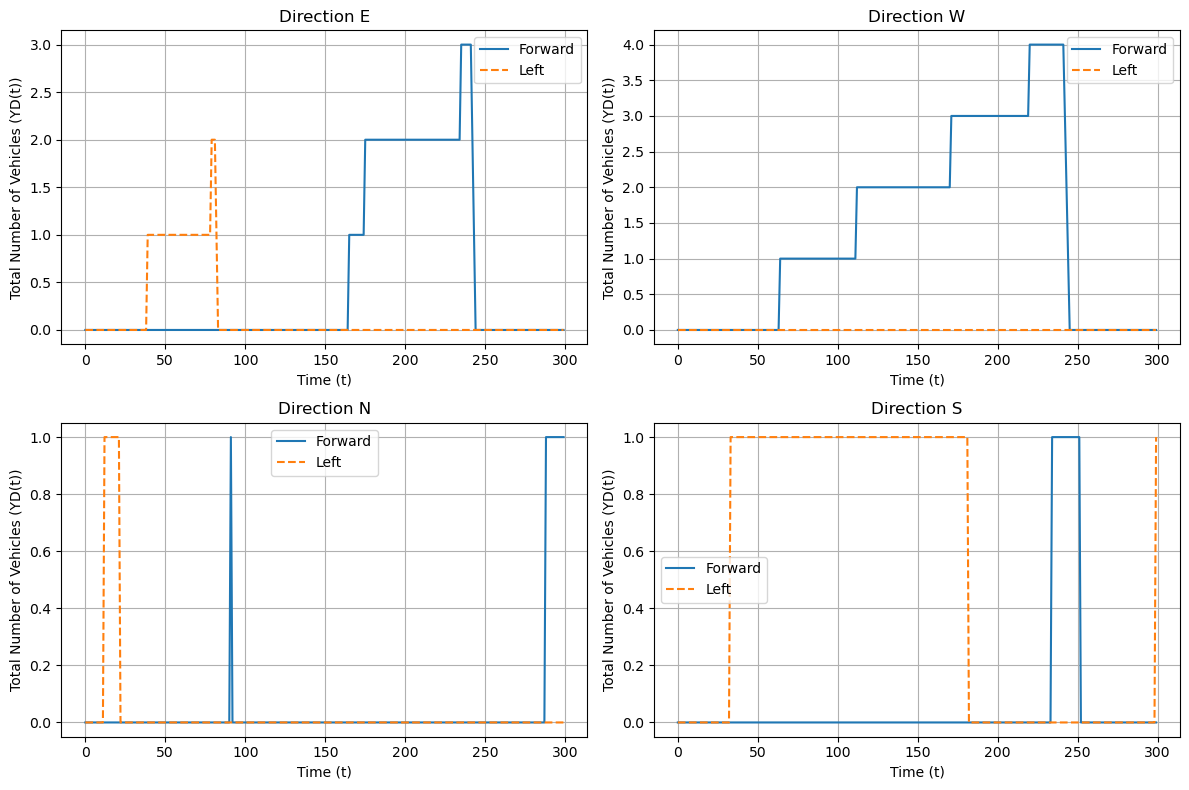

W: total average weight time per lane: 42.53921781336344s
average weight time per lane in s (nan means no cars arrived):
(E, F)     38.905095
(N, F)      0.824560
(W, F)     68.331260
(S, F)      4.972568
(E, L)     24.037520
(N, L)     10.814627
(W, L)           NaN
(S, L)    149.888895
dtype: float64


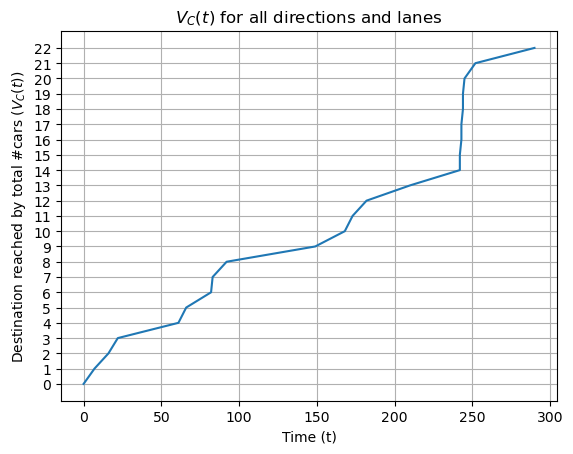

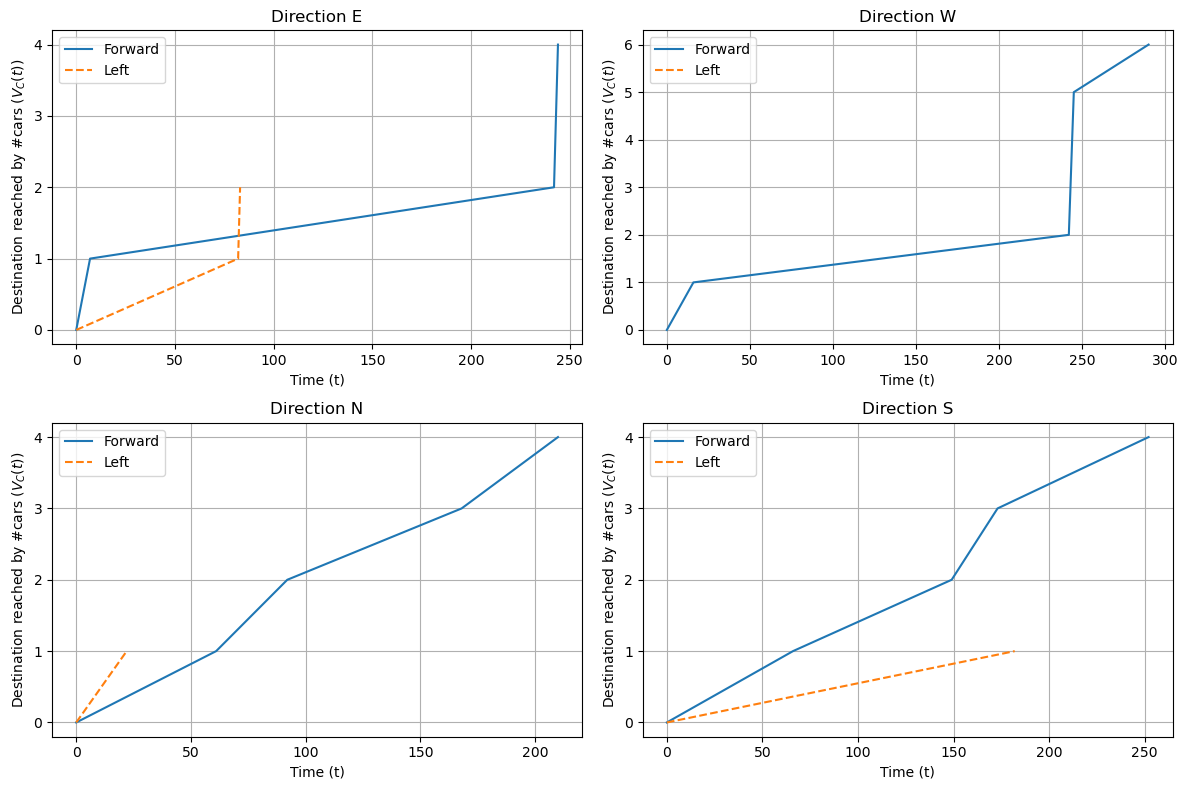

300
*********
With memory
*********


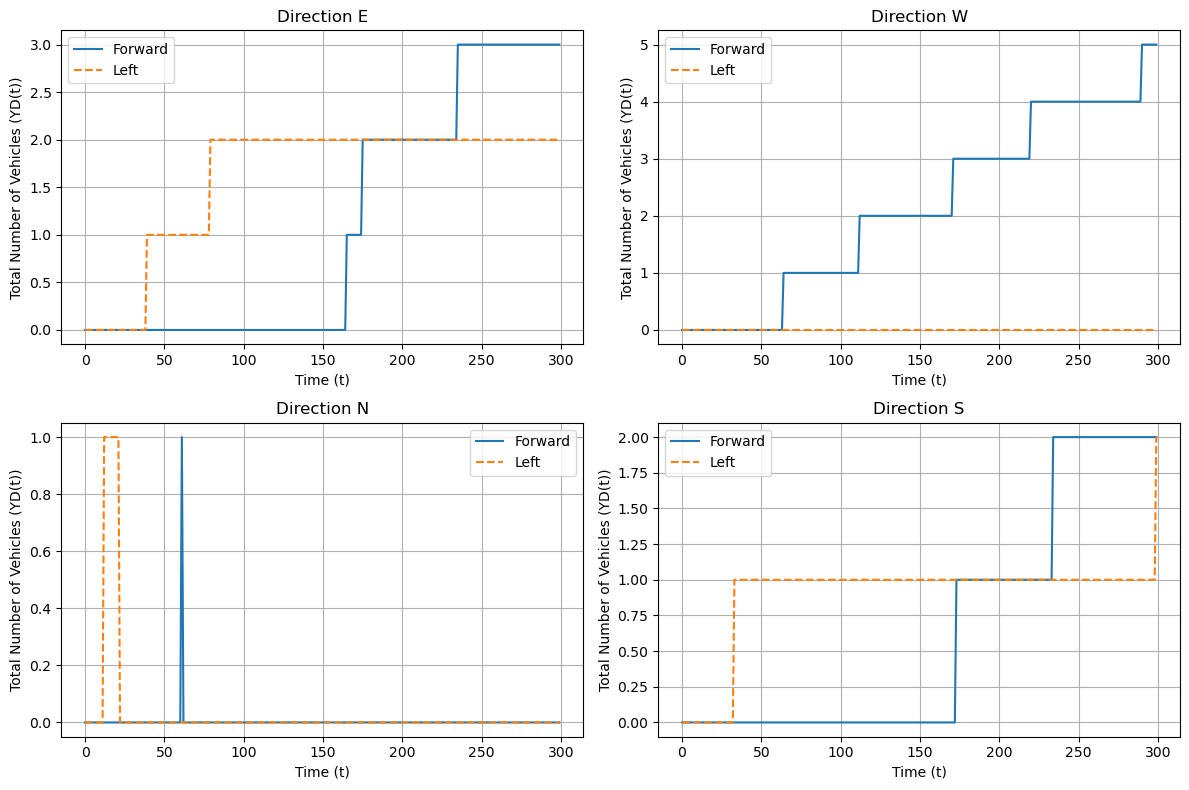

W: total average weight time per lane: 2.5432776696670367s
average weight time per lane in s (nan means no cars arrived):
(E, F)     0.441906
(N, F)     0.751778
(W, F)     0.058005
(S, F)     0.650072
(E, L)          NaN
(N, L)    10.814627
(W, L)          NaN
(S, L)          NaN
dtype: float64


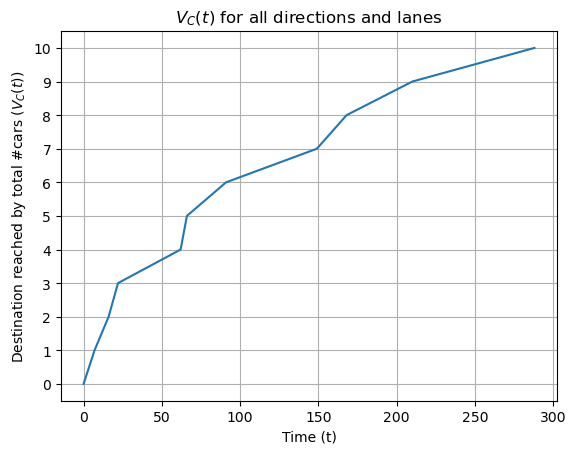

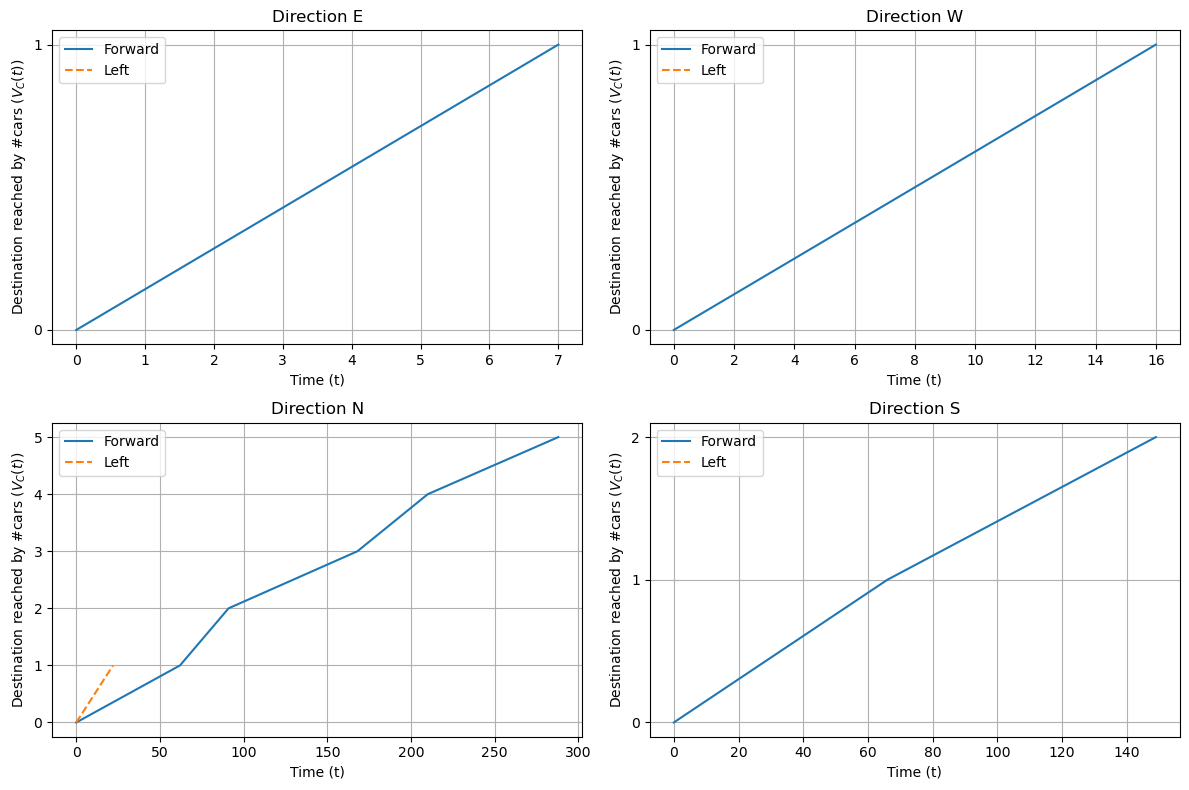

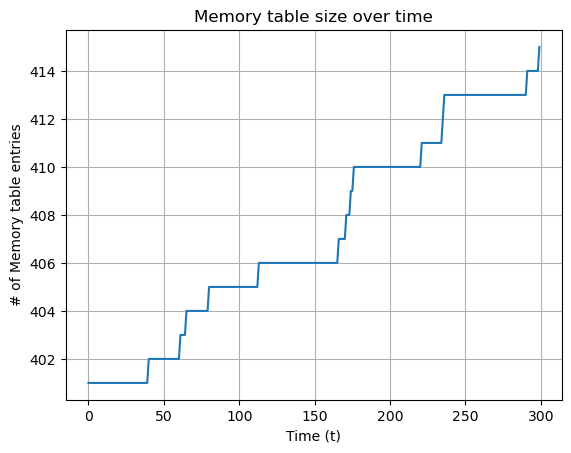

In [4]:
import time
# action space
A = [(['E', 'W'], ['F']), (['E', 'W'], ['L']), 
     (['N', 'S'], ['F']), (['N', 'S'], ['L']), 
     (['E'], ['F', 'L']), (['W'], ['F', 'L']), 
     (['N'], ['F', 'L']), (['S'], ['F', 'L'])]


def SARSA(lr=0.01, num_episodes=15, eps=0.3, gamma=0.95, eps_decay=0.00005):

    # Initialize the Q matrix
    # Q: matrix nS*nA where each row represent a state and each colums represent a different action
    games_reward = []
    test_rewards = []
    duration = 300

    # arrival rates in lamda platoons per second
    arrival_rates = {'E': 5/60, 'N': 5/60, 'W': 10/60, 'S': 7/60}
    # Initialize the signal index and duration for each signal
    signal_duration = 10
    states = x_state_t(duration=duration, action_duration=signal_duration, arrival_rates=arrival_rates, A=A)
    for ep in range(num_episodes):
        states.reset()
        done = False
        tot_rew = 0
        # decay the epsilon value until it reaches the threshold of 0.01
        if eps > 0.01:
            eps -= eps_decay
        # Define parameters
       
        timesteps = np.arange(1, duration + 1)
        while not done:
            #get next state
            next_state, reward, done = states.step()   
            tot_rew+=reward
            #get next action
            next_action = states.get_next_action(next_state=next_state)
            #update Qtable
            states.update_q_table(reward=reward, state_next=next_state, action_next=next_action, done=done)
            # print(f"({ep}) Elapsed time: {elapsed_time:.6f} seconds")
            if not done:
                states.apply_state(state=next_state, action=next_action)
            

        # print('For episode: {}, the total rewards is:{},  the Q table is:\n {}'.format(ep, tot_rew, states.q_table))
    print("Done")
    print("********")
    print("Test run:")
        
    '''
    Run some episodes to test the policy
    '''

    states.reset_test()
    states1 = copy.deepcopy(states)
    tot_rew = []    
    done = False
    game_rew = 0

    while not done:
        # select a greedy action
        next_state, rew, done = states.step()
        action = states.greedy(next_state)
        if not done:
            states.apply_state(next_state, action)
        game_rew += rew 
        if done:
            tot_rew.append(game_rew)
    print(f"Game {num_episodes}")
    states.plot_states()
    states.display_congestion_metric()
    

    tot_rew = []    
    done = False
    game_rew = 0
    while not done:
        # select a greedy action
        next_state, rew, done = states1.step_mem()
        action = states1.greedy_mem(next_state)
        if not done:
            states1.apply_state(next_state, action)
        states1.mem.update_size_time_array(states1.i)
        game_rew += rew 
        if done:
            tot_rew.append(game_rew)
    print(len(states1.states))
    print("*********")
    print("With memory")
    print("*********")
    states1.plot_states()
    states1.display_congestion_metric()
    

    plt.plot(range(0,duration), states1.mem.size_time)
    plt.xlabel("Time (t)")
    plt.ylabel('# of Memory table entries')
    plt.title("Memory table size over time")
    plt.grid(True)
    # Show the plot
    plt.show()  

    return states.q_table, states

Q, states = SARSA()


In [34]:
from scipy.spatial import KDTree

In [78]:
data = np.vstack(Q.index.map(x_state.to_numpy).values)
# print(data)

kd = KDTree(data)


# Assuming you have a KDTree named kd and a query point query_point
query_point = np.array([1, 0, 0, 0, 0, 0, 0, 0])

query_point2 = np.array([0, 0, 1, 0, 0, 0, 0, 0])
# Find points within a certain radius (e.g., radius=3)
indexes = kd.query_ball_point(query_point, r=1)




# Access the actual points using the indexes
nearby_points = data[indexes]

# Print or do something with the nearby points
print(nearby_points)
print()

print(data[kd.query_ball_point(query_point2, r=1)])

[[0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1]
 [1 0 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0]
 [2 0 0 0 0 0 0 0]]

[[0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 1]
 [0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0 0]]


In [43]:
rng = np.random.default_rng()
points1 = rng.random((15, 2))
points1

array([[0.32669043, 0.24494243],
       [0.12122702, 0.24276917],
       [0.67279373, 0.86323563],
       [0.85751229, 0.96015259],
       [0.72697898, 0.90281144],
       [0.28368794, 0.31079381],
       [0.83045632, 0.33539978],
       [0.30156921, 0.41156258],
       [0.4436276 , 0.97963368],
       [0.00625785, 0.69877623],
       [0.65641063, 0.39332383],
       [0.02645501, 0.76109694],
       [0.49148952, 0.81783345],
       [0.29515356, 0.06468015],
       [0.03023687, 0.92859513]])